In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import seaborn as sns
#import arviz as az
from os import listdir, makedirs
import pickle

In [6]:
# Data location
PROJECT_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/env-2'
DATA_PATH = f'{PROJECT_PATH}/data'
RESULTS_PATH = f'{PROJECT_PATH}/results'
TRANSITION_RESULTS_DIR = 'transition-influence'
TRANSITION_RESULTS_RESIDUALS_DIR = 'transition-influence-residuals'
FIG_PATH = f'{PROJECT_PATH}/figs'

# Model info
MODELS = [
    'ff_step-1_iper-1',
    'ff_step-2_iper-1',
    'ff_step-3_iper-1',
    'ff_step-4_iper-1',
    'ff_step-1_iper-2',
    'ff_step-2_iper-2',
    'ff_step-3_iper-2',
    'ff_step-4_iper-2',
    'ff_step-1_iper-3',
    'ff_step-2_iper-3',
    'ff_step-3_iper-3',
    'ff_step-4_iper-3',
    'ff_step-1_iper-4',
    'ff_step-2_iper-4',
    'ff_step-3_iper-4',
    'ff_step-4_iper-4'
]
N_PARAM_BINS = 5

# Aesthetics
MODEL_COLORS = {
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}
TRANSITION_INFLUENCE_COLORS = {
    'incidental': '#F52342',
    'true': '#FFBC42'
}

In [7]:
# Mkae figure path if it does not exist
makedirs(FIG_PATH, exist_ok=True)

# Functions

## Helper Functions

In [8]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def steps_and_dim_from_name(model):
    """
    Get number of steps and instances per conjunction from model label

    Arguments
    ---------
    model : str
        model label
    
    Returns
    -------
    steps : int
        number of steps
    iper : int
        instances per conjunction
    """
    steps = int(model.split('_')[1].split('-')[1])
    iper = int(model.split('_')[2].split('-')[1])
    return steps, iper

def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            np.abs(round(x.left, n)),
            np.abs(round(x.right, n))
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned

## Plot Functions

In [9]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            ci = None
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    elif y == 'resid':
        ax.axhline(.72, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Residual')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        max_reward = np.max(df['reward'])
        chance = max_reward/2
    elif y == 'p':
        chance = .25
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.set_ylim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)

# Load Data

## Training

In [10]:
# Load training data
training_df = []
for model in MODELS:
    steps, dim = steps_and_dim_from_name(model)
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/training')
    model_df['steps'] = steps
    model_df['dim'] = dim
    training_df.append(model_df)
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)
training_df['block'] = 1
training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,target,options,composition,successor,p,reward,correct,steps,dim,block
0,388,ff_step-1_iper-1,0.740784,0,0.034635,0.034635,1.0,0,2.332160,False,...,[0 0 0 1],[[[0 0 0 2]\n [0 0 0 3]]],[0 0 0 2],[0 0 0 1],0.500000,1,1,1,1,1
1,388,ff_step-1_iper-1,0.740784,0,0.034635,0.034635,1.0,0,2.332160,False,...,[0 0 4 0],[[[0 0 2 0]\n [0 0 3 0]]],[0 0 2 0],[0 0 1 0],0.500000,0,0,1,1,1
2,388,ff_step-1_iper-1,0.740784,0,0.034635,0.034635,1.0,0,2.332160,False,...,[0 0 0 1],[[[0 0 0 2]\n [0 0 0 3]]],[0 0 0 2],[0 0 0 1],0.498396,1,1,1,1,1
3,388,ff_step-1_iper-1,0.740784,0,0.034635,0.034635,1.0,0,2.332160,False,...,[4 0 0 0],[[[2 0 0 0]\n [3 0 0 0]]],[2 0 0 0],[1 0 0 0],0.500000,0,0,1,1,1
4,388,ff_step-1_iper-1,0.740784,0,0.034635,0.034635,1.0,0,2.332160,False,...,[0 4 0 0],[[[0 2 0 0]\n [0 3 0 0]]],[0 2 0 0],[0 1 0 0],0.500000,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11248635,385,ff_step-4_iper-4,0.469353,0,1.912474,1.912474,1.0,0,1.293893,False,...,[10 1 1 1],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[6 5 5 5],[10 1 1 1],1.000000,4,1,4,4,1
11248636,385,ff_step-4_iper-4,0.469353,0,1.912474,1.912474,1.0,0,1.293893,False,...,[10 1 1 10],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[6 5 5 5],[10 1 1 1],1.000000,3,0,4,4,1
11248637,385,ff_step-4_iper-4,0.469353,0,1.912474,1.912474,1.0,0,1.293893,False,...,[ 1 1 1 10],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[6 5 5 5],[10 1 1 1],1.000000,2,0,4,4,1
11248638,385,ff_step-4_iper-4,0.469353,0,1.912474,1.912474,1.0,0,1.293893,False,...,[10 1 1 10],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[6 5 5 5],[10 1 1 1],1.000000,3,0,4,4,1


## Test

In [11]:
test_df = []
for model in MODELS:
    steps, dim = steps_and_dim_from_name(model)
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/test')
    model_df['steps'] = steps
    model_df['dim'] = dim
    test_df.append(model_df)
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,options_comb,target,options,composition,successor,p,reward,correct,steps,dim
0,150,ff_step-1_iper-1,0.368180,0,0.158994,0.158994,1.0,0,3.841646,False,...,[1 0 0 0],[0 0 0 1],[[[2 0 0 0]\n [3 0 0 0]]],[3 0 0 0],[4 0 0 0],0.5,0,0,1,1
1,150,ff_step-1_iper-1,0.368180,0,0.158994,0.158994,1.0,0,3.841646,False,...,[1 0 0 0],[0 0 0 4],[[[2 0 0 0]\n [3 0 0 0]]],[2 0 0 0],[1 0 0 0],0.5,0,0,1,1
2,150,ff_step-1_iper-1,0.368180,0,0.158994,0.158994,1.0,0,3.841646,False,...,[1 0 0 0],[0 0 1 0],[[[2 0 0 0]\n [3 0 0 0]]],[2 0 0 0],[1 0 0 0],0.5,0,0,1,1
3,150,ff_step-1_iper-1,0.368180,0,0.158994,0.158994,1.0,0,3.841646,False,...,[1 0 0 0],[0 0 4 0],[[[2 0 0 0]\n [3 0 0 0]]],[2 0 0 0],[1 0 0 0],0.5,0,0,1,1
4,150,ff_step-1_iper-1,0.368180,0,0.158994,0.158994,1.0,0,3.841646,False,...,[1 0 0 0],[0 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]],[2 0 0 0],[1 0 0 0],0.5,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147131,149,ff_step-4_iper-4,0.788873,0,0.596984,0.596984,1.0,0,1.027141,False,...,[1 1 1 1],[10 10 1 10],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[6 6 5 6],[10 10 1 10],1.0,4,1,4,4
1147132,149,ff_step-4_iper-4,0.788873,0,0.596984,0.596984,1.0,0,1.027141,False,...,[1 1 1 1],[ 1 1 10 10],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[5 5 6 5],[ 1 1 10 1],1.0,3,0,4,4
1147133,149,ff_step-4_iper-4,0.788873,0,0.596984,0.596984,1.0,0,1.027141,False,...,[1 1 1 1],[ 1 10 10 10],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[5 5 6 5],[ 1 1 10 1],1.0,2,0,4,4
1147134,149,ff_step-4_iper-4,0.788873,0,0.596984,0.596984,1.0,0,1.027141,False,...,[1 1 1 1],[10 1 10 10],[[[5 0 0 0]\n [6 0 0 0]]\n\n [[0 5 0 0]\n [0...,[5 5 6 5],[ 1 1 10 1],1.0,2,0,4,4


## Representations

In [12]:
representations = {}
for model in MODELS:
    steps, dim = steps_and_dim_from_name(model)
    for fname in listdir(f'{DATA_PATH}/{model}/representations'):
        if fname.startswith('.'):
            continue
        agent_id = int(fname.split('_')[1].replace('.pkl', ''))
        with open(f'{DATA_PATH}/{model}/representations/{fname}', 'rb') as f:
            representations[model, agent_id] = standardize_reps_order(
                pickle.load(f)
            )
            representations[model, agent_id]['steps'] = steps
            representations[model, agent_id]['dim'] = dim

## Subject Information 

In [13]:
subj_df = test_df[['id', 'model_label', 'steps', 'dim', 'alpha', 'beta']]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df

,id,model_label,steps,dim,alpha,beta
0,150,ff_step-1_iper-1,1,1,0.368180,0.158994
1,636,ff_step-1_iper-1,1,1,0.923443,5.284279
2,622,ff_step-1_iper-1,1,1,0.896862,0.855406
3,144,ff_step-1_iper-1,1,1,0.493794,1.166861
4,178,ff_step-1_iper-1,1,1,0.737182,0.507651
...,...,...,...,...,...,...
14957,161,ff_step-4_iper-4,4,4,0.508661,2.882154
14958,607,ff_step-4_iper-4,4,4,0.428691,2.834464
14959,613,ff_step-4_iper-4,4,4,0.852439,1.240283
14960,175,ff_step-4_iper-4,4,4,0.739558,3.207027


## Transition Influence

### Results

In [55]:
trans_influence_df = []
for model in ['ff']:#MODELS:
    this_path = f'{RESULTS_PATH}/{model}/{TRANSITION_RESULTS_DIR}'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        agent_id = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        coefs = coefs.reshape(-1, 2)
        
        try:
            # Add to full results set
            coefs_df = pd.DataFrame({
                'id': agent_id,
                'action': [1, 2, 3],
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })
            trans_influence_df.append(coefs_df)

        except:

            print(f'ISSUE WITH AGENT {agent_id} COEFS')

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information
trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = 'id'
)

trans_influence_df

ISSUE WITH AGENT 568 COEFS


,id,action,transition,coef,model_label,alpha,beta,segmentation
0,792,1,incidental,0.501,ff,0.119485,1.225985,0.227770
1,792,2,incidental,-0.009,ff,0.119485,1.225985,0.227770
2,792,3,incidental,-0.013,ff,0.119485,1.225985,0.227770
3,792,1,true,4.339,ff,0.119485,1.225985,0.227770
4,792,2,true,3.769,ff,0.119485,1.225985,0.227770
...,...,...,...,...,...,...,...,...
5941,953,2,incidental,0.163,ff,0.582714,0.011191,0.530584
5942,953,3,incidental,0.224,ff,0.582714,0.011191,0.530584
5943,953,1,true,0.394,ff,0.582714,0.011191,0.530584
5944,953,2,true,0.922,ff,0.582714,0.011191,0.530584


### Residuals

In [56]:
# Load all residuals into a single DataFrame
residuals_df = []
for model in ['ff']:#MODELS:
    this_path = f'{RESULTS_PATH}/{model}/{TRANSITION_RESULTS_RESIDUALS_DIR}'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        residuals_df.append(pd.read_csv(f'{this_path}/{fname}'))
residuals_df = pd.concat(residuals_df, ignore_index=True)

# Select only the residuals for the executed action
idx = np.eye(4, dtype=bool)[residuals_df['action'].values]
resid = np.array(residuals_df)[:, -4:]
residuals_df['resid'] = resid[idx]
residuals_df = residuals_df[['id', 'trial', 'action', 'resid']]

# Add block information
residuals_df = pd.merge(
    residuals_df,
    training_df[['id', 'trial', 'block']],
    on = ['id', 'trial']
)

# Add parameter information
residuals_df = pd.merge(
    residuals_df,
    subj_df,
    on = 'id'
)

residuals_df

,id,trial,action,resid,block,model_label,alpha,beta,segmentation
0,28,1,1,0.747125,1,ff,0.072220,0.832806,0.568870
1,28,2,2,0.968000,1,ff,0.072220,0.832806,0.568870
2,28,3,0,0.855125,1,ff,0.072220,0.832806,0.568870
3,28,4,3,0.949625,1,ff,0.072220,0.832806,0.568870
4,28,5,1,0.948000,1,ff,0.072220,0.832806,0.568870
...,...,...,...,...,...,...,...,...,...
51355,201,476,0,0.002750,2,ff,0.893842,2.169727,0.952422
51356,201,477,1,0.000375,2,ff,0.893842,2.169727,0.952422
51357,201,478,3,0.004875,2,ff,0.893842,2.169727,0.952422
51358,201,479,3,0.001625,2,ff,0.893842,2.169727,0.952422


### Plot successor representations learned for agent = 1

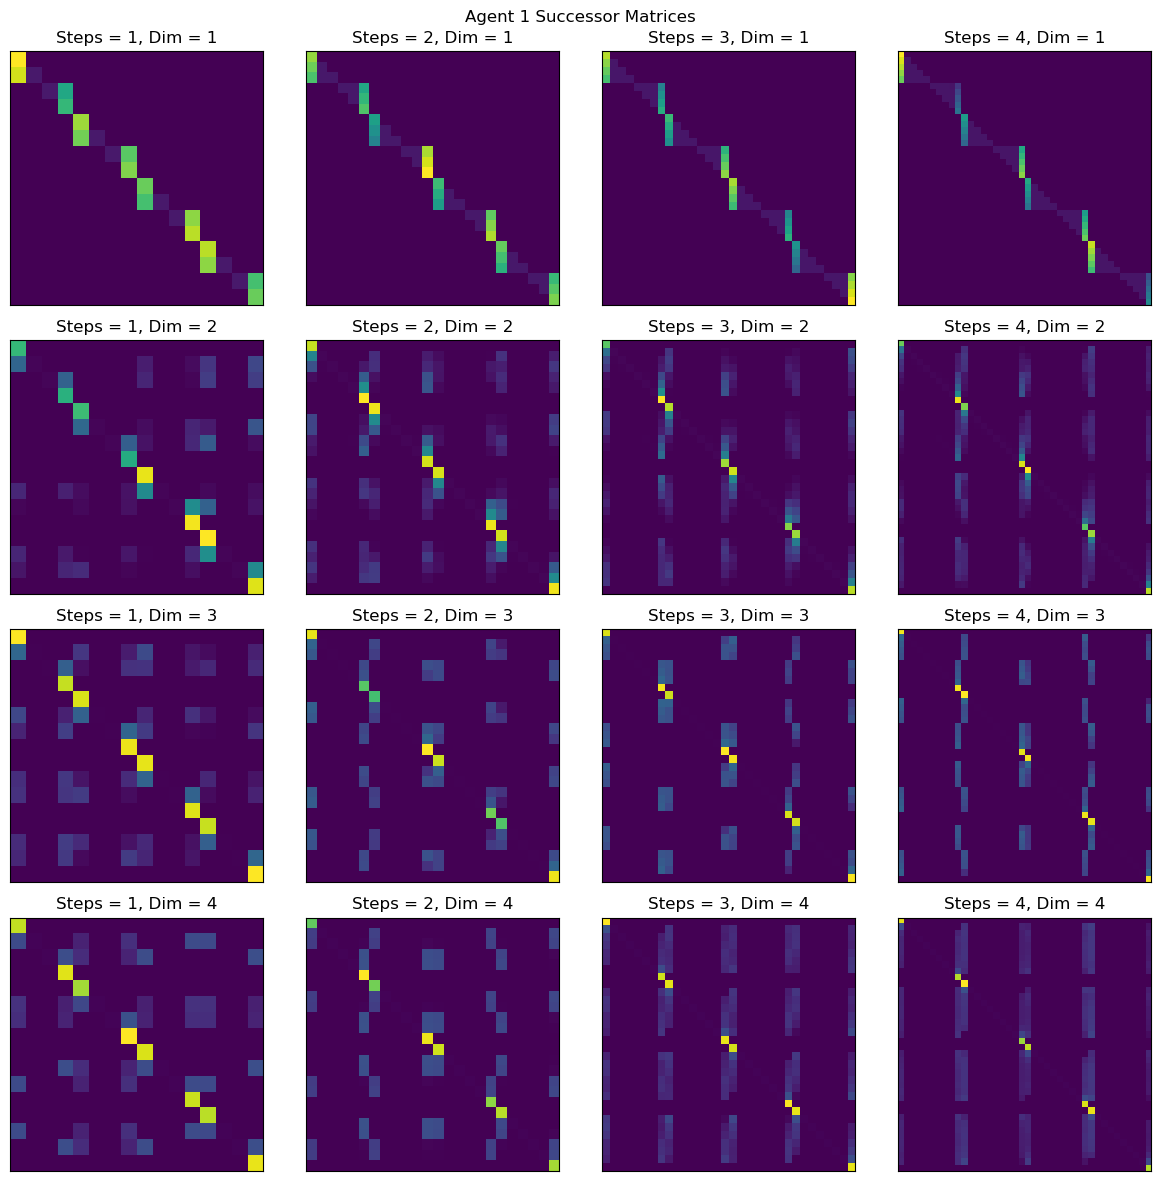

In [14]:
agent_id = 1
n_subplots = len(MODELS)
n_cols = 4
n_rows = int(np.ceil(n_subplots/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, model in enumerate(MODELS):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(representations[model, agent_id]['M'])
    steps = representations[model, agent_id]['steps']
    dim = representations[model, agent_id]['dim']
    ax.set_title(f'Steps = {steps}, Dim = {dim}')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'Agent {agent_id} Successor Matrices')
fig.tight_layout()

## Plot weight of incidental versus true information in successor matrices

### Get incidental vs true information weight

In [15]:
def get_M_masks(key):
     feats = []
     for lab in representations[key]['row_labels']:
          if len(lab) == 5:
              lab = lab.replace('10', 'a')
          feats.append([i != '0' for i in lab])
     feats = np.array(feats)
     true_mask = feats@feats.T
     incidental_mask = np.logical_not(true_mask)
     np.fill_diagonal(true_mask, False)
     return true_mask, incidental_mask

In [16]:
# Get incidental weights for each model and agent
incidental_weights = []
n_agents = int(len(representations)/len(MODELS))
for model in MODELS:
    for i in range(1, n_agents + 1):

        try:

            # Get within- (true) and between-feature (incidental) masks
            true_mask, incidental_mask = get_M_masks((model, i))

            # Sum information in true vs incidental regions of M
            M = representations[model, i]['M']
            true_sum = np.sum(M[true_mask])
            incidental_sum = np.sum(M[incidental_mask])

            # Get ratio of incidental to true information
            incidental_weight = incidental_sum/(true_sum + incidental_sum)

            # Add to DataFrame
            incidental_weights.append({
                'id': i,
                'model_label': model,
                'steps': representations[model, i]['steps'],
                'dim': representations[model, i]['dim'],
                'incidental_weight': incidental_weight
            })

        except:
            continue

# Convert to data frame
incidental_weights_df = pd.DataFrame(incidental_weights)
incidental_weights_df

,id,model_label,steps,dim,incidental_weight
0,1,ff_step-1_iper-1,1,1,0.000000
1,2,ff_step-1_iper-1,1,1,0.000000
2,3,ff_step-1_iper-1,1,1,0.000000
3,4,ff_step-1_iper-1,1,1,0.000000
4,5,ff_step-1_iper-1,1,1,0.000000
...,...,...,...,...,...
14056,931,ff_step-4_iper-4,4,4,0.750000
14057,932,ff_step-4_iper-4,4,4,0.750000
14058,933,ff_step-4_iper-4,4,4,0.750000
14059,934,ff_step-4_iper-4,4,4,0.749940


### Plot incidental weight in successor matrix by dimensionality and steps

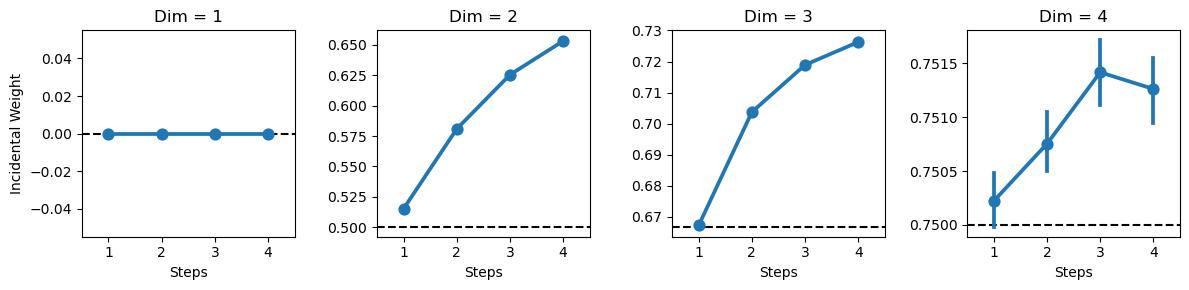

In [19]:
n_subplots = len(MODELS)//4
fig, axs = plt.subplots(1, n_subplots, figsize=(n_subplots*3, 3))
for i, dim in enumerate([1, 2, 3, 4]):
        ax = axs[i]
        ax.axhline((dim - 1)/dim, color='black', linestyle='--')
        idx = incidental_weights_df['dim'] == dim
        sns.pointplot(
                data = incidental_weights_df.loc[idx],
                x = 'steps',
                y = 'incidental_weight',
                ax = ax
        )
        if i == 0:
                ax.set_ylabel('Incidental Weight')
        else:
                ax.set_ylabel('')
        ax.set_xlabel('Steps')
        ax.set_title(f'Dim = {dim}')

fig.tight_layout()

# Training Analysis

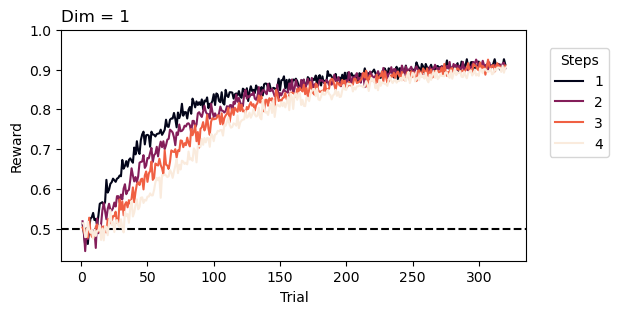

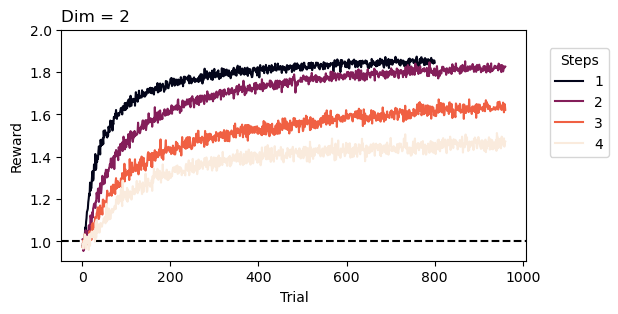

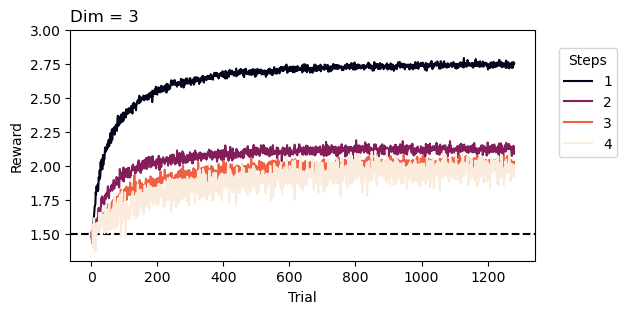

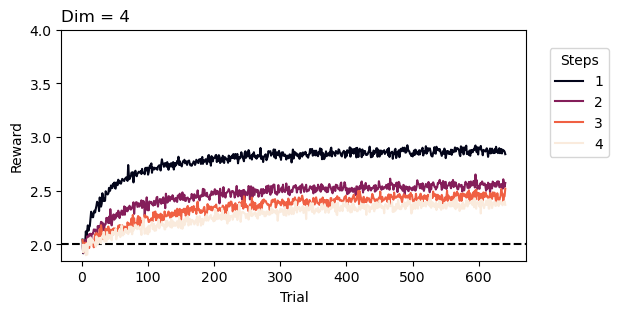

In [20]:
idx = training_df['dim'] == 1
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'steps',
    legend_title = 'Steps',
    title = 'Dim = 1',
    #palette = MODEL_COLORS
)

idx = training_df['dim'] == 2
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'steps',
    legend_title = 'Steps',
    title = 'Dim = 2',
    #palette = MODEL_COLORS
)

idx = training_df['dim'] == 3
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'steps',
    legend_title = 'Steps',
    title = 'Dim = 3',
    #palette = MODEL_COLORS
)

idx = training_df['dim'] == 4
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'steps',
    legend_title = 'Steps',
    title = 'Dim = 4',
    #palette = MODEL_COLORS
)

### Transition Influence

In [18]:
def plot_transition_influence_by_param(
    data,
    x,
    x_label = None,
    palette = {
        'incidental': None,
        'true': None
    },
    title = None,
    fname = False
):
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(0, color='black', linestyle='--', zorder=0)

    # Plot true-transition influence
    idx = data['transition'] == 'true'
    sns.regplot(
        data = data.loc[idx],
        x = x,
        y = 'coef',
        scatter_kws = {'s': 1},
        color = palette['true'],
        label = 'True',
        ax = ax
    )

    # Plot incidental transition influence
    idx = data['transition'] == 'incidental'
    sns.regplot(
        data = data.loc[idx],
        x = x,
        y = 'coef',
        scatter_kws = {'s': 1},
        color = palette['incidental'],
        label = 'Incidental',
        ax = ax
    )
    ax.legend(markerscale=4)
    ax.set_ylabel('Transition Influence')
    ax.set_xlabel(x_label)
    ax.set_title(title, loc='left')
    fig.tight_layout()
    if fname:
        fig.savefig(fname)

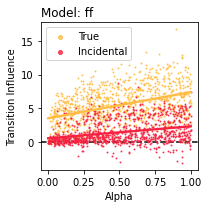

In [71]:
# ff transition influence by alpha
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'alpha',
    x_label = 'Alpha',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Model: ff',
)

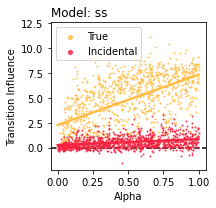

In [72]:
# ss transition influence by alpha
idx = trans_influence_df['model_label'] == 'ss'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'alpha',
    x_label = 'Alpha',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Model: ss',
)

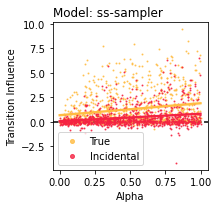

In [73]:
# ss-sampler transition influence by alpha
idx = trans_influence_df['model_label'] == 'ss-sampler'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'alpha',
    x_label = 'Alpha',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Model: ss-sampler',
)

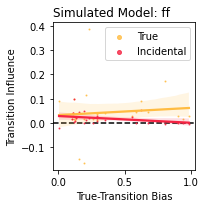

In [51]:
# ff transition influence by segmentation
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'segmentation',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'segmentation',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'segmentation',
    x_label = 'True-Transition Bias',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Simulated Model: ff',
    fname = f'{FIG_PATH}/transition_influence_by_segmentation.pdf'
)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_85980/4173936989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['segmentation_bin'] = bin_params(


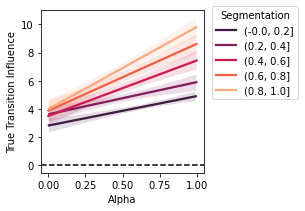

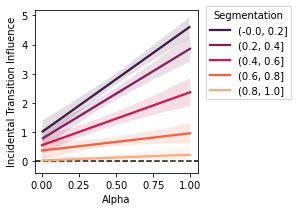

In [75]:
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx]
plot_df['segmentation_bin'] = bin_params(
        plot_df['segmentation'],
        N_PARAM_BINS
)

idx = plot_df['transition'] == 'true'
plot_param_interaction(
        plot_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'True Transition Influence',
        palette = 'rocket'
)

idx = plot_df['transition'] == 'incidental'
plot_param_interaction(
        plot_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Incidental Transition Influence',
        palette = 'rocket'
)

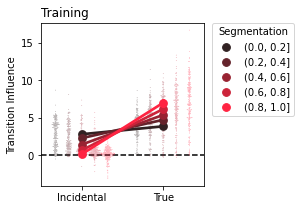

In [66]:
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx]
plot_df['segmentation_bin'] = bin_params(
        plot_df['segmentation'],
        N_PARAM_BINS
)
plot_df = plot_df[['id', 'transition', 'segmentation_bin', 'coef']]
plot_df = plot_df.groupby(['id', 'transition', 'segmentation_bin'])
plot_df = plot_df.mean().reset_index()
plot_df = plot_df.dropna()

# Make palette that goes from block to MODEL_COLORS['ff'] color


fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='black', linestyle='--', zorder=0)
sns.swarmplot(
    data = plot_df,
    x = 'transition',
    y = 'coef',
    hue = 'segmentation_bin',
    s = .75,
    alpha = .5,
    palette = sns.color_palette(f'dark:{MODEL_COLORS["ff"]}', N_PARAM_BINS),
    dodge = True,
    zorder = 0
)
sns.pointplot(
    data = plot_df,
    x = 'transition',
    y = 'coef',
    hue = 'segmentation_bin',
    palette = sns.color_palette(f'dark:{MODEL_COLORS["ff"]}', N_PARAM_BINS),
    ax = ax
)

handles, labels = plt.gca().get_legend_handles_labels()
ax.legend(handles[:5], labels[:5], title='Segmentation', loc=(1.05, .43))
ax.set_xlabel(None)
ax.set_xticklabels(['Incidental', 'True'])
ax.set_ylabel('Transition Influence')
ax.set_title('Training', loc='left')
set_axis_ratio(ax)


## Residuals analysis

### Trial-wise residuals by model

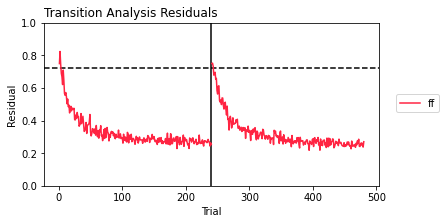

In [75]:
plot_training_curve(
    residuals_df,
    'resid',
    'model_label',
    palette = MODEL_COLORS,
    title = 'Transition Analysis Residuals'
)

### Trial-wise residuals for feature-based model

In [76]:
# Get feature-based model data
idx = residuals_df['model_label'] == 'ff'
ff_residuals_df = residuals_df.loc[idx]
ff_residuals_df = ff_residuals_df.reset_index(drop=True)

# Bin parameters
ff_residuals_df['alpha_bin'] = bin_params(
    ff_residuals_df['alpha'],
    N_PARAM_BINS
)
ff_residuals_df['beta_bin'] = bin_params(
    ff_residuals_df['beta'],
    N_PARAM_BINS,
    method = pd.qcut
)
ff_residuals_df['segmentation_bin'] = bin_params(
    ff_residuals_df['segmentation'],
    N_PARAM_BINS
)

#### Residuals by learning rate

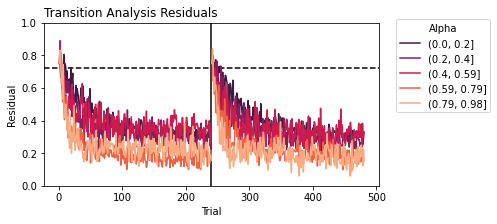

In [77]:
plot_training_curve(
    ff_residuals_df,
    'resid',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha',
    title = 'Transition Analysis Residuals'
)

#### Residuals by inverse temperature parameter

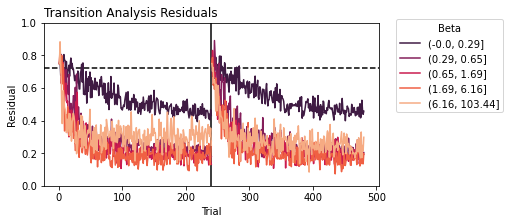

In [78]:
plot_training_curve(
    ff_residuals_df,
    'resid',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta',
    title = 'Transition Analysis Residuals'
)

#### Residuals by segmentation

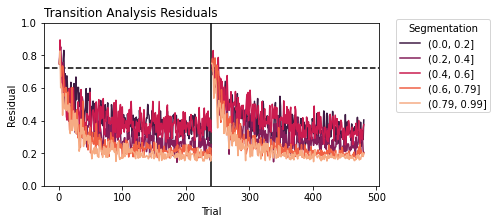

In [79]:
plot_training_curve(
    ff_residuals_df,
    'resid',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Transition Analysis Residuals'
)

# Representations

124.96792194529971

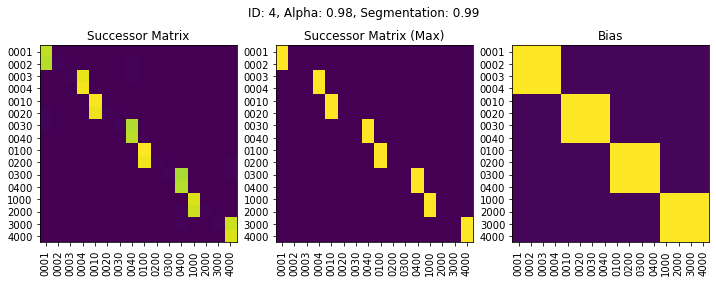

In [44]:
subj = 4
subj_alp = np.round(representations[subj]['agent_info']['alpha'], 2)
subj_seg = np.round(representations[subj]['agent_info']['segmentation'], 2)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(representations[subj]['M'])
axs[0].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[0].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[0].set_title('Successor Matrix')

axs[1].imshow(np.array([row == np.max(row) for row in representations[subj]['M']]))
axs[1].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[1].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[1].set_title('Successor Matrix (Max)')

axs[2].imshow(representations[subj]['bias'], vmin=0, vmax=1)
axs[2].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[2].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[2].set_title('Bias')

fig.suptitle(f'ID: {subj}, Alpha: {subj_alp}, Segmentation: {subj_seg}')

np.max(representations[subj]['M'])

In [177]:
conjs = np.array(np.meshgrid(*[range(5)]*4)).T.reshape(-1, 4)
idx = np.sum(conjs > 0, axis = 1) == 2
conjs = conjs[idx]
idx = np.logical_not(
    np.any(np.isin(conjs, [2, 3]), axis=1) &
    np.any(np.isin(conjs, [1, 3]), axis=1)
)
conjs = conjs[idx]
conjs = representations[1]['S']
conj_labels = [''.join(conj) for conj in conjs.astype(str)]
conjs

array([[0, 0, 1, 1],
       [0, 0, 1, 4],
       [0, 0, 2, 2],
       [0, 0, 2, 3],
       [0, 0, 3, 2],
       [0, 0, 3, 3],
       [0, 0, 4, 1],
       [0, 0, 4, 4],
       [1, 1, 0, 0],
       [1, 4, 0, 0],
       [2, 2, 0, 0],
       [2, 3, 0, 0],
       [3, 2, 0, 0],
       [3, 3, 0, 0],
       [4, 1, 0, 0],
       [4, 4, 0, 0]])

In [187]:
loseg_rdm = np.zeros((len(representations[1]['M']), len(representations[1]['M'])))
hiseg_rdm = loseg_rdm.copy()
loseg_conj_rdm = np.zeros((len(conjs), len(conjs)))
hiseg_conj_rdm = loseg_conj_rdm.copy()
ss_conj_rdm = hiseg_conj_rdm.copy()
hiseg_count = 0
loseg_count = 0 
ss_count = 0 
for key in representations.keys():
    if representations[key]['agent_info']['model_label'] == 'ff':
        M = representations[key]['M']

        rdm = np.zeros((len(M), len(M)))
        for i in range(len(M)):
            for j in range(i + 1, len(M)):
                dist = np.linalg.norm(M[i] - M[j])
                rdm[i, j] = dist
                rdm[j, i] = dist

        
        M_conj = np.zeros((len(conjs), len(representations[key]['M'][0])))
        for i, conj in enumerate(conjs):
            feats = np.eye(len(conj))*conj
            feats = feats[np.any(feats, axis=1)]
            for feat in feats:
                idx = np.all(feat == representations[key]['F_raw'], axis=1)
                M_conj[i] += representations[key]['M'][idx][0]

        M_conj_rdm = np.zeros((len(M_conj), len(M_conj)))
        for i in range(len(M_conj)):
            for j in range(i + 1, len(M_conj)):
                dist = np.linalg.norm(M_conj[i] - M_conj[j])
                M_conj_rdm[i, j] = dist
                M_conj_rdm[j, i] = dist

        if representations[key]['agent_info']['segmentation'] > .8:
            hiseg_rdm += rdm
            hiseg_conj_rdm += M_conj_rdm
            hiseg_count += 1
        elif representations[key]['agent_info']['segmentation'] < .2: 
            loseg_rdm += rdm
            loseg_conj_rdm += M_conj_rdm
            loseg_count += 1


    elif representations[key]['agent_info']['model_label'] == 'ss':
        
        M = representations[key]['M']
        M_conj_rdm = np.zeros(np.shape(M))
        for i in range(len(M_conj_rdm)):
            idx_i = np.all(representations[key]['S'] == conjs[i], axis=1)
            for j in range(i + 1, len(M_conj_rdm)):
                idx_j = np.all(representations[key]['S'] == conjs[j], axis=1)
                dist = np.linalg.norm(M[idx_i] - M[idx_j])
                M_conj_rdm[i, j] = dist
                M_conj_rdm[j, i] = dist
        try:
            ss_conj_rdm += M_conj_rdm
            ss_count += 1
        except:
            continue


hiseg_rdm /= hiseg_count
loseg_rdm /= loseg_count
hiseg_conj_rdm /= hiseg_count
loseg_conj_rdm /= loseg_count
ss_conj_rdm /= ss_count


Text(0.5, 1.0, 'High Segmentation RDM')

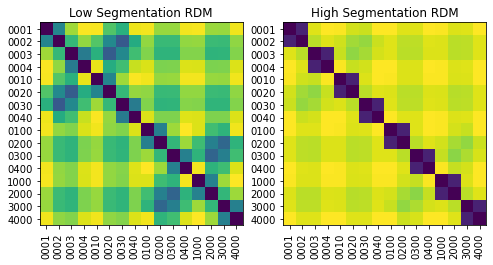

In [188]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(loseg_rdm)
axs[1].imshow(hiseg_rdm)
axs[0].set_xticks(
    np.arange(len(representations[1]['col_labels'])),
    labels = representations[1]['col_labels'],
    size = 10,
    rotation = 90
)
axs[0].set_yticks(
    np.arange(len(representations[1]['row_labels'])),
    labels = representations[1]['row_labels']
)
axs[0].set_title('Low Segmentation RDM')
axs[1].set_xticks(
    np.arange(len(representations[1]['col_labels'])),
    labels = representations[1]['col_labels'],
    size = 10,
    rotation = 90
)
axs[1].set_yticks(
    np.arange(len(representations[1]['row_labels'])),
    labels = representations[1]['row_labels']
)
axs[1].set_title('High Segmentation RDM')

Text(0.5, 1.0, 'Conjunctive RDM')

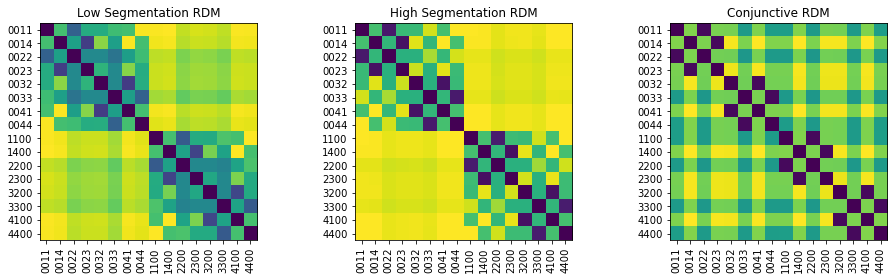

In [189]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(loseg_conj_rdm)
axs[1].imshow(hiseg_conj_rdm)
axs[2].imshow(ss_conj_rdm)
axs[0].set_xticks(
    np.arange(len(conj_labels)),
    labels = conj_labels,
    size = 10,
    rotation = 90
)
axs[0].set_yticks(
    np.arange(len(conj_labels)),
    labels = conj_labels
)
axs[0].set_title('Low Segmentation RDM')

axs[1].set_xticks(
    np.arange(len(conj_labels)),
    labels = conj_labels,
    size = 10,
    rotation = 90
)
axs[1].set_yticks(
    np.arange(len(conj_labels)),
    labels = conj_labels
)
axs[1].set_title('High Segmentation RDM')

axs[2].set_xticks(
    np.arange(len(conj_labels)),
    labels = conj_labels,
    size = 10,
    rotation = 90
)
axs[2].set_yticks(
    np.arange(len(conj_labels)),
    labels = conj_labels
)
axs[2].set_title('Conjunctive RDM')

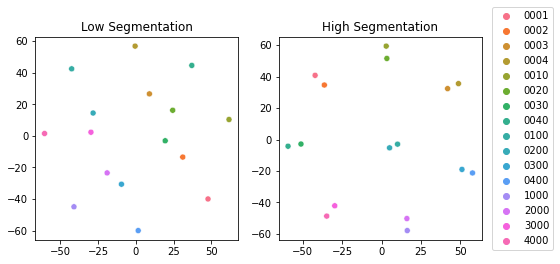

In [96]:
from sklearn.manifold import MDS

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity="precomputed")
reduced_data = mds.fit_transform(loseg_rdm)

sns.scatterplot(
    x = reduced_data[:, 0],
    y = reduced_data[:, 1],
    hue = representations[1]['row_labels'],
    ax = axs[0]
)
axs[0].get_legend().remove()
axs[0].set_title('Low Segmentation')
set_axis_ratio(axs[0])

# Apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity="precomputed")
reduced_data = mds.fit_transform(hiseg_rdm)

sns.scatterplot(
    x = reduced_data[:, 0],
    y = reduced_data[:, 1],
    hue = representations[1]['row_labels'],
    ax = axs[1]
)

axs[1].legend(loc=(1.05, -.05))
axs[1].set_title('High Segmentation')
set_axis_ratio(axs[1])



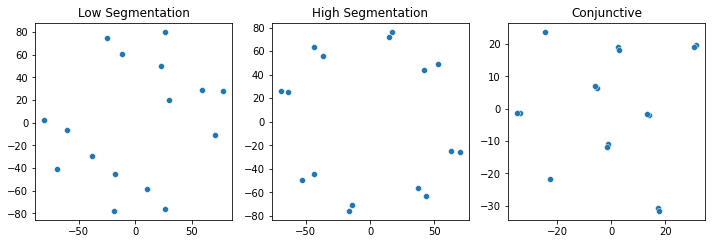

In [190]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity="precomputed")
reduced_data = mds.fit_transform(loseg_conj_rdm)

sns.scatterplot(
    x = reduced_data[:, 0],
    y = reduced_data[:, 1],
    #hue = conj_labels,
    ax = axs[0]
)
#axs[0].get_legend().remove()
axs[0].set_title('Low Segmentation')
set_axis_ratio(axs[0])

# Apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity="precomputed")
reduced_data = mds.fit_transform(hiseg_conj_rdm)

sns.scatterplot(
    x = reduced_data[:, 0],
    y = reduced_data[:, 1],
    #hue = conj_labels,
    ax = axs[1]
)

#axs[1].legend(loc=(1.05, -.05))
axs[1].set_title('High Segmentation')
set_axis_ratio(axs[1])

# Apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity="precomputed")
reduced_data = mds.fit_transform(ss_conj_rdm)

sns.scatterplot(
    x = reduced_data[:, 0],
    y = reduced_data[:, 1],
    #hue = conj_labels,
    ax = axs[2]
)

#axs[1].legend(loc=(1.05, -.05))
axs[2].set_title('Conjunctive')
set_axis_ratio(axs[2])



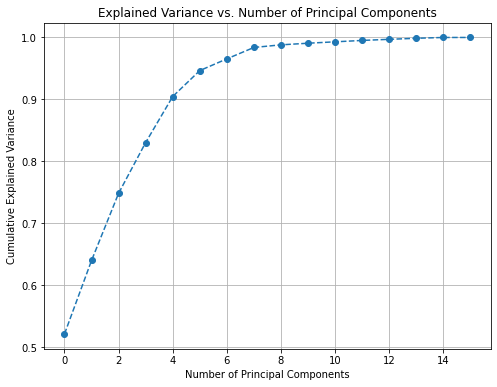

Number of components to explain 95.0% variance: 7


In [191]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(loseg_conj_rdm)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Compute the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Print the explained variance for each component
#for i, variance in enumerate(explained_variance_ratio, 1):
#    print(f"Component {i}: {variance:.4f}")

# Optionally, you can print the number of components needed to explain 95% variance
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components to explain {threshold*100}% variance: {num_components}")

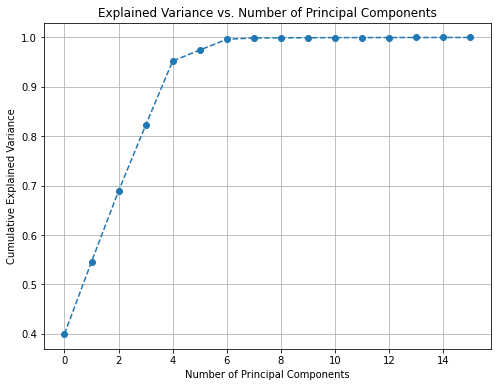

Number of components to explain 95.0% variance: 5


In [192]:
pca = PCA()
pca.fit(hiseg_conj_rdm)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Compute the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Print the explained variance for each component
#for i, variance in enumerate(explained_variance_ratio, 1):
#    print(f"Component {i}: {variance:.4f}")

# Optionally, you can print the number of components needed to explain 95% variance
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components to explain {threshold*100}% variance: {num_components}")

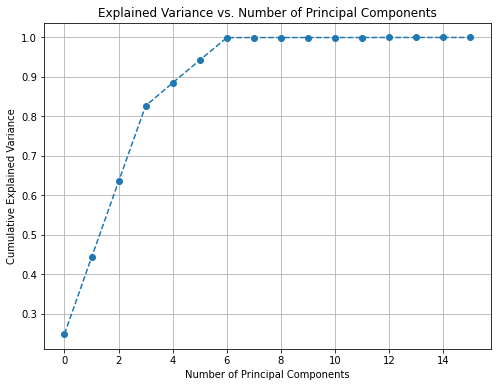

Number of components to explain 95.0% variance: 7


In [198]:
pca = PCA()
pca.fit(ss_conj_rdm)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Compute the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Print the explained variance for each component
#for i, variance in enumerate(explained_variance_ratio, 1):
#    print(f"Component {i}: {variance:.4f}")

# Optionally, you can print the number of components needed to explain 95% variance
threshold = 0.95
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components to explain {threshold*100}% variance: {num_components}")

<AxesSubplot:ylabel='Count'>

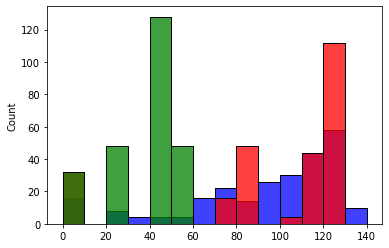

In [197]:
sns.histplot(loseg_conj_rdm.flatten(), color='blue', binwidth=10)
sns.histplot(hiseg_conj_rdm.flatten(), color='red', binwidth=10)
sns.histplot(ss_conj_rdm.flatten(), color='green', binwidth=10)

<AxesSubplot:ylabel='Count'>

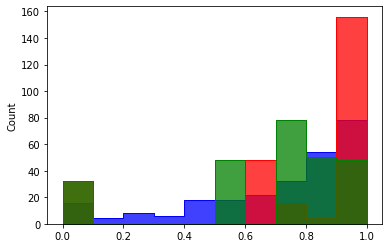

In [200]:
sns.histplot(loseg_conj_rdm.flatten()/np.max(loseg_conj_rdm.flatten()), color='blue', binwidth=.1, element="step")
sns.histplot(hiseg_conj_rdm.flatten()/np.max(hiseg_conj_rdm.flatten()), color='red', binwidth=.1, element="step")
sns.histplot(ss_conj_rdm.flatten()/np.max(ss_conj_rdm.flatten()), color='green', binwidth=.1, element="step")